In [6]:
%matplotlib inline
import matplotlib
import seaborn as sns
matplotlib.rcParams['savefig.dpi'] = 144

In [7]:
import pandas as pd
import numpy as np
from sklearn import base
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.linear_model import LinearRegression, SGDRegressor
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
import matplotlib.pyplot as plt
from scipy import stats

# Anomaly Detection

This notebook presents a case study for detecting anomalies in time series data.

**Anomaly detection**, or novelty detection, is attempting to find data that look different from the majority of the data. It is typically an unsupervised learning system, since the anomalous data is not labeled. We must detect it by learning what the normal data look like.

For example data, we will be using ridership of the New York CitiBike bike sharing system.  The full data are available [online](https://s3.amazonaws.com/tripdata/index.html), but we will be using a data file in which the ridership has already be aggregated by day.

Finding out if a day had an unusual number of riders might be useful for a number of reasons.  If there are an extra 5,000 riders one day, we probably want to know.  Was a particular advertisement very effective?  Did a celebrity tweet about the program?  Was there some event that attracted a lot of riders?  Regardless, marketing can probably use this information to refocus their efforts.

More importantly, if we're missing 5,000 riders we expected, something has gone wrong.  Did credit card processing break?  Did a backend server go down?  Did our redistribution scheme fail, leaving empty bike racks where the users are?  Or was there some unexpected failure mode that we weren't checking for?  Whatever it was, we want to know ASAP, so we can address it.

And this is true in general.  Any time your business has data coming in regularly, you want to know when its behaving abnormally.  Sometimes it's something that needs to be fixed.  Other times it's a sign that something's working better than it used to.  Either way, you want to know.

In [8]:
counts = pd.read_csv('tripdata/citibike.csv').set_index('date')['count']
counts.index = pd.to_datetime(counts.index, format='%Y-%m-%d')
counts.head()

date
2013-07-01    16650
2013-07-02    22745
2013-07-03    21864
2013-07-04    22326
2013-07-05    21842
Name: count, dtype: int64

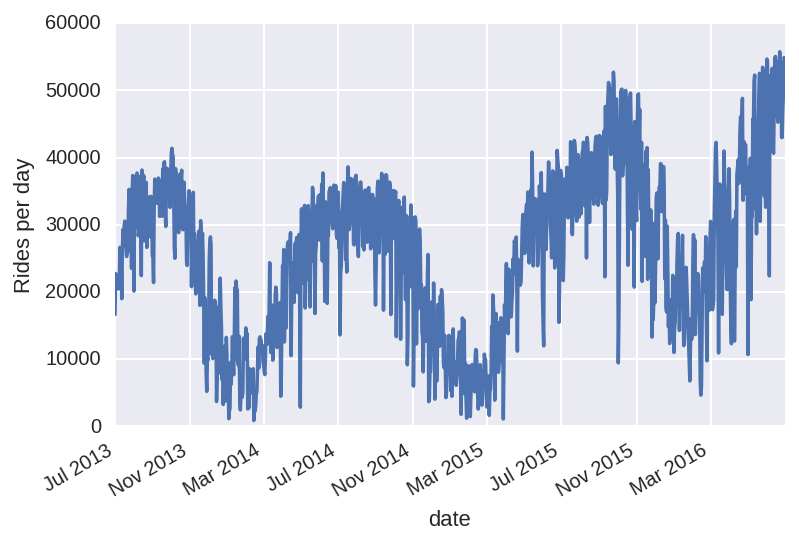

In [9]:
counts.plot()
plt.ylabel('Rides per day')

## Modeling the background

There are clearly days in this data that do not follow the overall trend.  For example, there is a day in early October, 2015, which has much less ridership than we would expect.  However, this amount of ridership wwould be perfectly normal in the winter of 2014 or 2015.  To make this stand out, we build a model of the the expected ridership.

## Detecting seasonality with Fourier Transforms

Seasonality is the periodic correlation of a time series with itself.  Fourier analysis can be used to detect seasonality that occurs over all time.

In this case, we plot the **power spectrum** of the signal, which is the Fourier transform times its conjugate, or equivalently the square of the absolute value of the transform.  In many cases in physics, the power in a signal goes like the square of the amplitude.  In these cases, the power spectrum describes the power per unit frequency contained in that signal.

Looking at the lower frequency components, we can clearly see the yearly cycle that's obvious by eye.

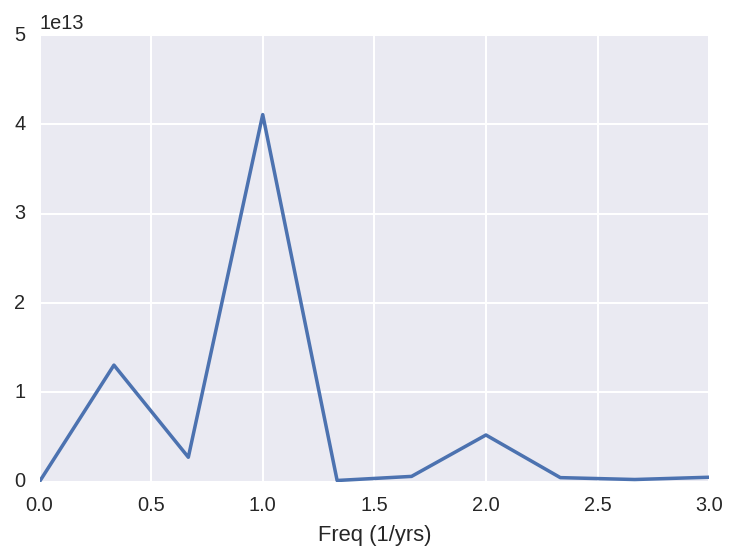

In [10]:
fft_counts = np.fft.fft(counts - counts.mean())
yrs = (counts.index[-1] - counts.index[0]).days / 365.

plt.plot(1.0*np.arange(len(fft_counts)) / yrs, np.abs(fft_counts)**2)
plt.axis([0,3, 0, 5e13])
plt.xlabel('Freq (1/yrs)')

**Question:** What does the peak at 2/year indicate?

Changing focus to some higher frequencies, we can cleary see the weekly cycle, at 52/year.

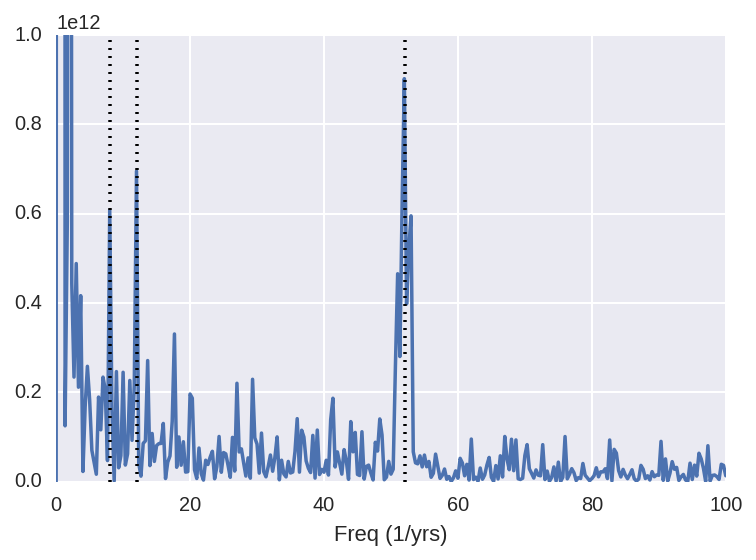

In [11]:
plt.plot(1.0*np.arange(len(fft_counts)) / yrs, np.abs(fft_counts)**2)
plt.axis([0,100, 0, 1e12])
plt.xlabel('Freq (1/yrs)')
plt.axvline(365/7., color='k', ls=':')
plt.axvline(12, color='k', ls=':')
plt.axvline(8, color='k', ls=':')

**Question:** There are clear peaks at 12/year and 8/year.  What might cause these?

## Detrending

The yearly cycle appears to be rather sinusoidal, so we account for it with a single Fourier term:

$$ f(t) = A \sin\frac{2\pi t}{365} + B\cos\frac{2\pi t}{365} + f_0 \ . $$

Since we know the frequency, we can fit the coefficients $A$, $B$, and $f_0$ with linear regression.  To do so, we need to make additional features for the sine and cosine terms.

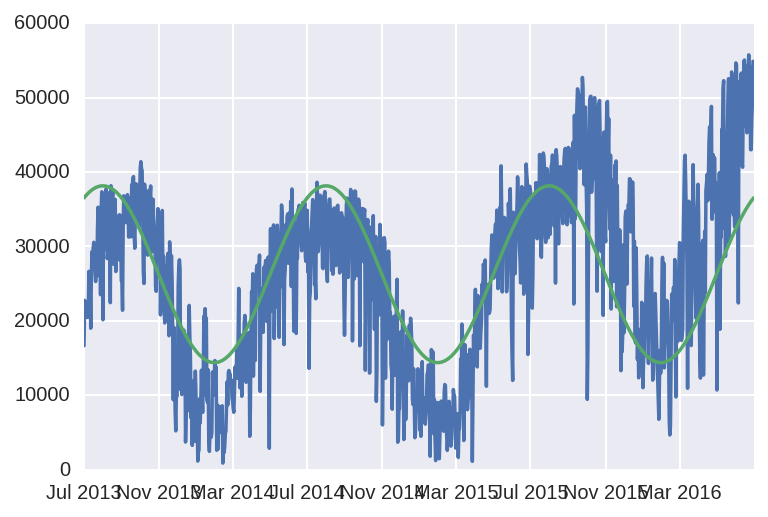

In [12]:
class FourierComponents(base.BaseEstimator, base.TransformerMixin):
    
    def __init__(self, period):
        self.period = period
    
    def fit(self, X, y=None):
        self.X0 = X[0]
        return self
    
    def transform(self, X):
        dt = (X - self.X0).days * 2 * np.pi / self.period
        return np.c_[np.sin(dt), np.cos(dt)]

pipe = Pipeline([('fourier', FourierComponents(365)),
                 ('lr', LinearRegression())])
pipe.fit(counts.index, counts)
plt.plot(counts.index, counts, counts.index, pipe.predict(counts.index))

How well are we doing?  A good baseline is the mean model, which has a MSE equal to the variance of the data.  We'll take the square root to look at RMSE.

In [13]:
np.sqrt(counts.var())

12250.136374096797

This model is definitely an improvement.

In [14]:
np.sqrt(metrics.mean_squared_error(counts, pipe.predict(counts.index)))

8919.6020407194228

### Weekly cycle

We could add a weekly Fourier term, but we don't know if it's really sinusoidal.  If we group the results by day of the week, we can get a better feel for the cycle.

([<matplotlib.axis.XTick at 0x7f0e5de98e50>,
 <a list of 7 Text xticklabel objects>)

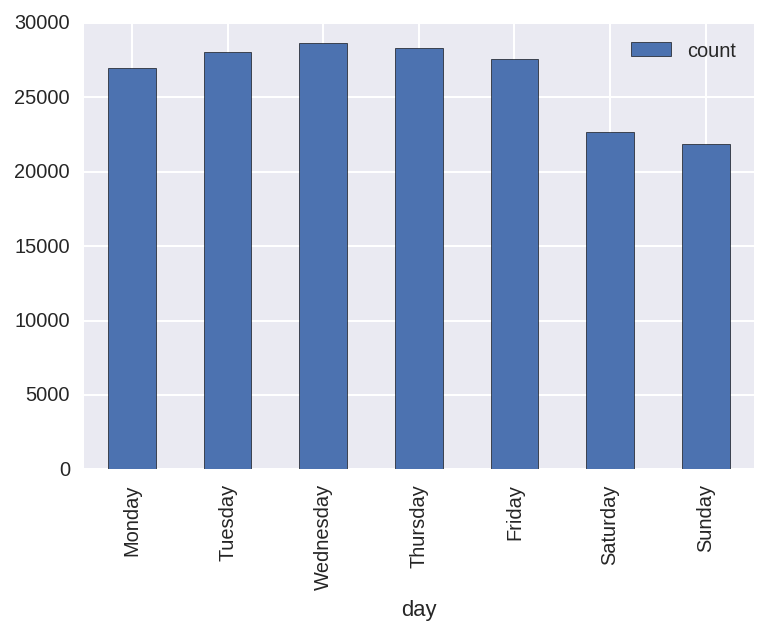

In [15]:
day_df = pd.DataFrame(
    {'day': counts.index.dayofweek, 'count': counts.values}
)
day_df.groupby('day').mean().plot(kind='bar')
plt.xticks(range(7), ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])

The weekly cycle is not particularly sinusoidal.  Instead of treating the day of the week as a continuous variable, we will treat it as a categorical feature.  We will use one-hot encoding of the day of the week.  When this is fed into a linear regression, it produces per-category means.

In [16]:
class DayofWeek(base.BaseEstimator, base.TransformerMixin):
    
    def fit(self, X, y=None):
        return self
    
    def day_vector(self, day):
        v = np.zeros(7)
        v[day] = 1
        return v
    
    def transform(self, X):
        return np.stack(self.day_vector(d) for d in X.dayofweek)

union = FeatureUnion([('fourier', FourierComponents(365)),
                      ('dayofweek', DayofWeek())])
pipe = Pipeline([('union', union),
                 ('lr', LinearRegression())])

pipe.fit(counts.index, counts)
np.sqrt(metrics.mean_squared_error(counts, pipe.predict(counts.index)))

8532.0814714059597

To understand what a model is doing correctly, and what it's missing, it's useful to plot the **residual**, the difference between the actual and predicted values.

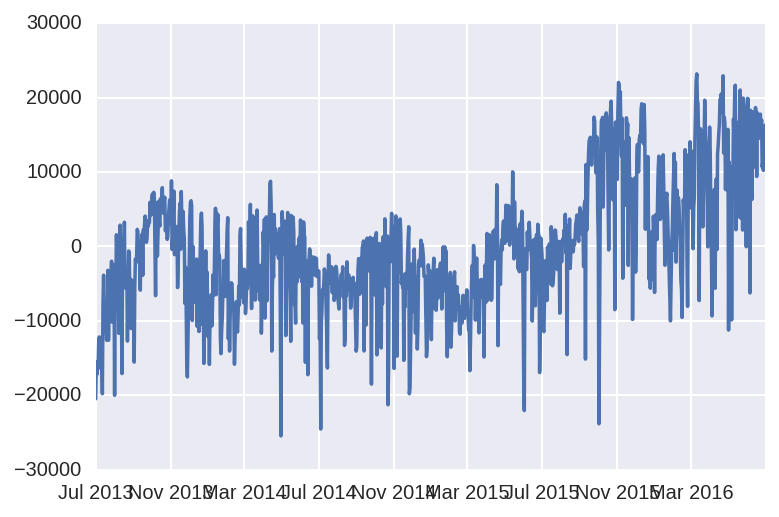

In [17]:
plt.plot(counts - pipe.predict(counts.index))

Ridership has been growing with time.  The growth doesn't appear to be linear, but quadratic might be a good fit.  It's simple to add two more features representing $t$ and $t^2$ to attempt to fit this background growth.

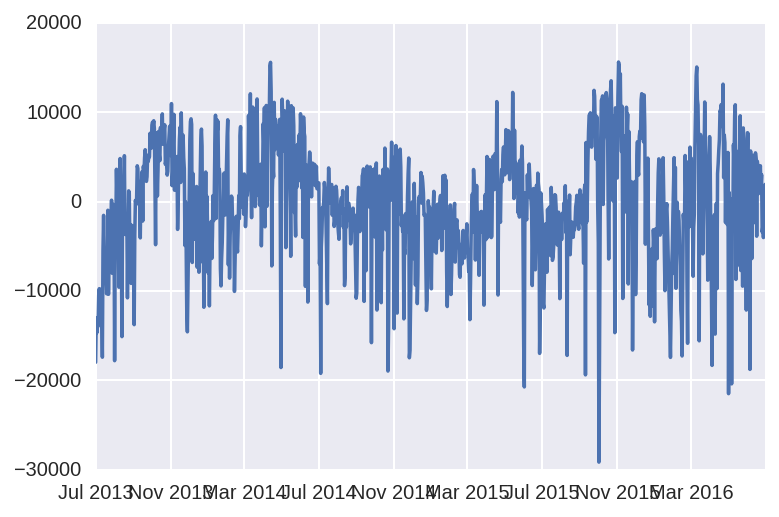

In [18]:
class QuadBackground(base.BaseEstimator, base.TransformerMixin):
    
    def fit(self, X, y=None):
        self.X0 = X[0]
        return self
    
    def transform(self, X):
        days = (X - self.X0).days
        return np.c_[days, days**2]

union = FeatureUnion([('date', QuadBackground()),
                      ('fourier', FourierComponents(365)),
                      ('dayofweek', DayofWeek())])
pipe = Pipeline([('union', union),
                 ('lr', LinearRegression())])

pipe.fit(counts.index, counts.values)
plt.plot(counts - pipe.predict(counts.index))

In [19]:
np.sqrt(metrics.mean_squared_error(counts, pipe.predict(counts.index)))

6502.0455715592234

**Exercises**

1. Account for the monthly seasonality.  Examine how ridership varies over the month.  Develop a model to account for this.  How much does this improve the RMSE?

2. It seems reasonable to assume that weather affects the usage of the CitiBike system.  The `projects/anomaly/nycp.csv` file contains daily National Weather Service records for Central Park.  Add features from these records to your model.  Does this improve the RMSE of the model?  How much does ridership increase for every degree Fahrenheit?  (Hint: The coefficients of the linear model are stored in the `.coef_` attribute of a `LinearRegression` object.)

### Full background model

In addition to the yearly Fourier term and weekly binning, we have added monthly, bianual, and 8/year Fourier components.

In [20]:
union = FeatureUnion([('date', QuadBackground()),
                      ('fourier-y', FourierComponents(365)),
                      ('fourier-2', FourierComponents(365/2.)),
                      ('fourier-m', FourierComponents(365/12.)),
                      ('fourier-8', FourierComponents(365/8.)),
                      ('dayofweek', DayofWeek())])
pipe = Pipeline([('union', union),
                 ('lr', LinearRegression())])
pipe.fit(counts.index, counts.values)
np.sqrt(metrics.mean_squared_error(counts, pipe.predict(counts.index)))

5850.8116537276774

This is a fair improvement on our previous RMSE.

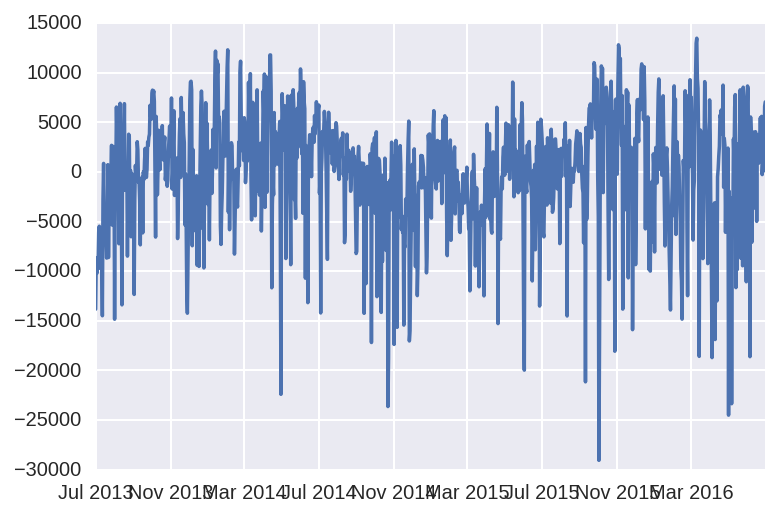

In [21]:
residuals = counts - pipe.predict(counts.index)
plt.plot(residuals)

## z-Score

From the residuals plot above, we can fairly easily see which values are likely to be anomalous: those far from zero.  We can quantify this measure with some results from statistics.

Suppose that we have a probability distribution with mean $\mu$ and standard devation $\sigma$.  If the distribution is single-peaked, we expect most random variables pulled from it to lie within about $1\sigma$ of $\mu$.  Now, we ask whether a particular value $y$ was likely to have been drawn from that distribution.  The **z-score** measures how far $y$ is from the mean, normalized by the standard deviation:

$$ z = \frac{y - \mu}\sigma \ . $$

Many random variables follow the Gaussian, or normal, distribution.  This is the common bell curve, which is parameterized by its mean and standard deviation:

$$ p(x) = \frac{1}{\sqrt{2 \pi} \sigma} \exp \left(\frac{(x - \mu)^2}{2 \sigma^2} \right) \ . $$

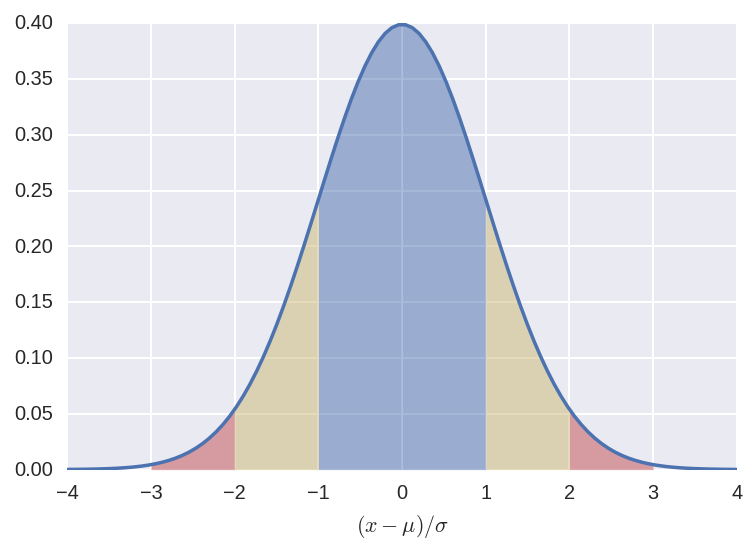

In [22]:
x = np.linspace(-4, 4, 100)
dist = stats.norm()
cols = sns.color_palette()[::2]
cols = [cols[1], cols[2], cols[0], cols[0], cols[2], cols[1]]
plt.plot(x, dist.pdf(x))
for xm in xrange(-2, 4):
    x = np.linspace(xm-1, xm, 20)
    plt.fill_between(x, dist.pdf(x), alpha=0.5, lw=0, facecolor=cols[xm+2])
plt.xlabel(r'$(x - \mu) / \sigma$')

For a Gaussian, there is 68% chance of a random variable lying within $1\sigma$ of the mean (blue), a 95% chance of it lying withing $2\sigma$ (blue and yellow), and a 99.7% chance of it lying within $3\sigma$ (blue, yellow and red).  Thus, the higher the z-score of a value, the less likely it is to have been drawn from that distribution.

Of course, different distributions have different shapes, so these probabilities are not universal.  Nonetheless, for single-peaked distributions, the general pattern holds.

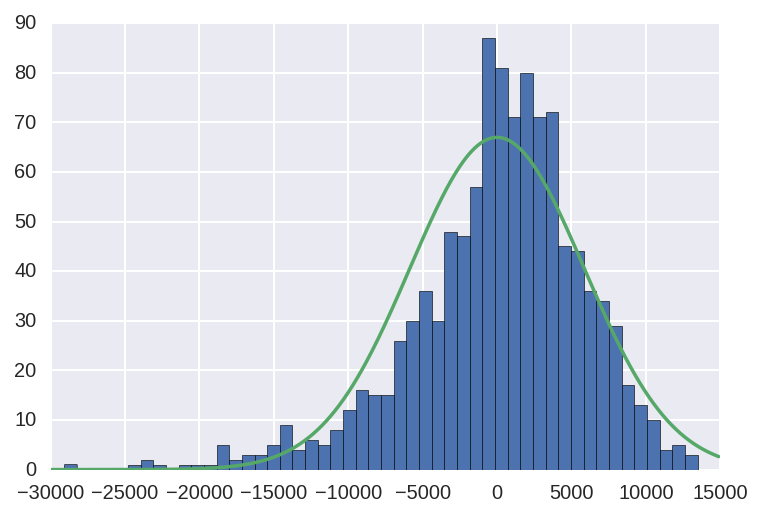

In [23]:
residuals.hist(bins=50)
x = np.arange(-30000, 15000, 100)
dist = stats.norm(scale=residuals.std())
plt.plot(x, dist.pdf(x) * 45000 / 50. * len(residuals))

The residuals are not distributed normally, but we can still use large (absolute) z-scores as an indicator.

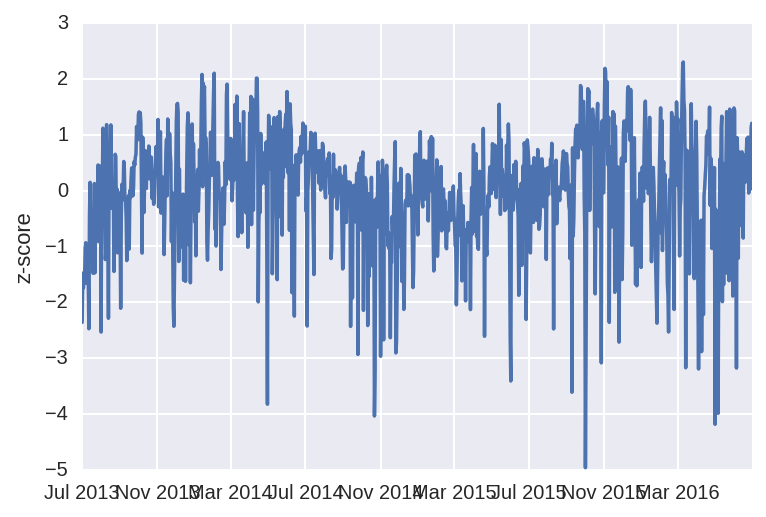

In [24]:
z = residuals / residuals.std()
plt.plot(z)
plt.ylabel('z-score')

Since the distrbution of residuals is not symmetric about 0, we will consider different thresholds for positive and negative z values.

In [25]:
z[z > 2]

date
2014-01-13    2.081930
2014-02-02    2.103765
2014-04-12    2.015333
2014-04-13    2.015708
2015-11-03    2.190268
2015-11-04    2.131025
2016-03-09    2.217649
2016-03-10    2.303934
Name: count, dtype: float64

Looking at news reports, we can try to understand what might have caused these events.  We can find that March 9 and 10 of 2016 were particularly nice.  High temperatures were in the 70s, unusual for March in New York.

In [26]:
z[z < -3.5]

date
2014-04-30   -3.828525
2014-10-22   -4.039171
2015-09-10   -3.613741
2015-10-02   -4.965583
2016-05-01   -4.187608
2016-05-06   -3.990278
Name: count, dtype: float64

We can now see that early October, 2015, event occurred on the 2nd.  It happens that on this day, a nor'easter blew through New York.

## Moving-Window Averages

One thing to note about this results is that most of the anomalous counts are rather recent.  Looking at the residuals, we can see why: There seems to be more variation in the recent data.  This suggests that we should be looking for measures that compare the latest results only to contemporary data.

This is the domain of **moving-window averages**.  Instead of calculating values over the whole of the domain, we do the calculation over a window.  As we move forward in time, this window moves with us.  There are a number of window shapes we could use, but we will start with a simple square window of the last $k$ measurements.  Pandas makes it easy to calculate the mean and standard deviation over those windows.

<function __main__.func>

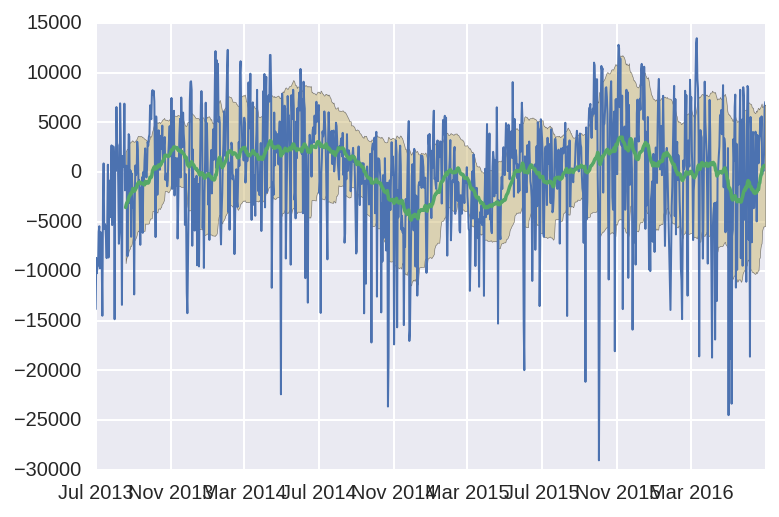

In [27]:
from ipywidgets import interact

def plot_rolling(x):
    
    def func(window=50):
        rolling = x.rolling(window=window)
        plt.plot(x, lw=1)
        mean = rolling.mean()
        std = rolling.std()
        plt.fill_between(mean.index, mean+std, mean-std, facecolor=cols[1], alpha=0.5)
        plt.plot(rolling.mean())
    
    return func

interact(plot_rolling(residuals), window=(5, 100, 5))

If we use these rolling values for mean and standard deviation, we get the **moving z-score**.

In [28]:
def rolling_z(x, window):
    roll_mean = x.rolling(window=window).mean().shift(1) # Don't include current data
    roll_std = x.rolling(window=window).std().shift(1)
    return (x - roll_mean) / roll_std

<function __main__.<lambda>>

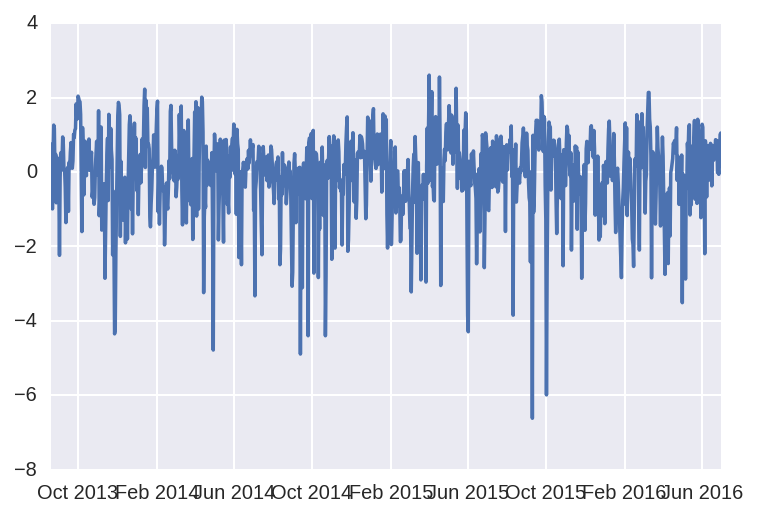

In [29]:
def plot_rolling_z(x):
    return lambda window: plt.plot(rolling_z(x, window)) and None

interact(plot_rolling_z(residuals), window=(5, 100, 5))

While the choice of window size will always reflect a balance between the need to respond to new baselines while still noticing anomalous behavior, we can get an estimate for the size of the window we should use from the autocorrelation of the residuals.  In this case, the strong correlation only lasts about 5 days.

(0, 40)

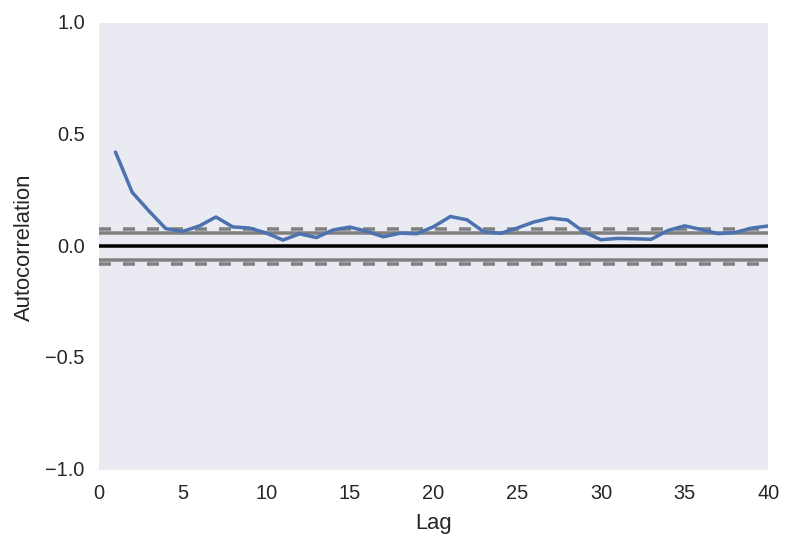

In [30]:
pd.tools.plotting.autocorrelation_plot(residuals)
plt.xlim(0,40)

In [31]:
rolling_z(residuals, 5)[rolling_z(residuals, 5) > 5]

date
2013-10-28    5.600237
2014-03-08    6.210163
2015-09-24    5.153240
Name: count, dtype: float64

In [32]:
rolling_z(residuals, 5)[rolling_z(residuals, 5) < -10]

date
2013-10-06   -16.670652
2014-07-02   -10.080202
2014-09-13   -16.849386
2014-10-01   -14.506062
2014-10-11   -13.980488
2014-11-01   -10.928027
2015-03-28   -10.182186
2015-11-26   -11.189694
Name: count, dtype: float64

The October nor'easter no longer stands out as strongly.  Ridership fell for several days before the storm (perhaps due to precursor weather), so the drop on the day of the storm is less surprising.

One new date that appears is worth noting: March 28, 2015.  On this day, the CitiBike program was suddenly [shut down for software fixes](http://www.nytimes.com/2015/03/31/nyregion/citi-bike-apologizing-for-abrupt-shutdown-says-service-will-improve.html?_r=0).

### Exponential Window

A particularly simple windowing average is the **exponentially-weighted moving average** (EWMA).  The value at time $t$ is given by

$$ E_t = \alpha X_t + (1 - \alpha) E_{t-1}\ . $$

This has the effect of previous measurements fade away by a factor of $1 - \alpha$ each step.  Previous values are never entirely forgotten, but they fade away bit by bit.  This simple form makes it easy to calculate.  Regardless of the window size, we need hold only the previous value of the moving average in memory.

There are several ways to specify the parameter; here we use the **half-life**,

$$ h = \log_2 \frac{1}{1-\alpha} \ . $$

<function __main__.func>

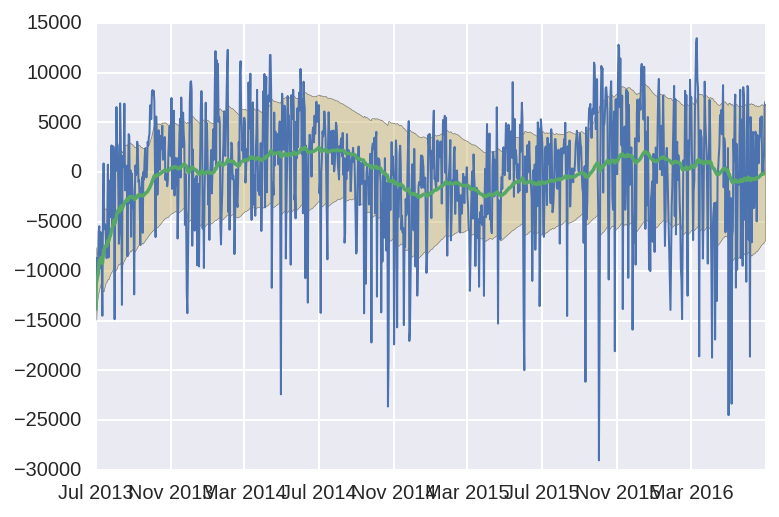

In [33]:
def plot_ewm(x):
    
    def func(halflife=50):
        rolling = x.ewm(halflife=halflife)
        plt.plot(x, lw=1)
        mean = rolling.mean()
        std = rolling.std()
        plt.fill_between(mean.index, mean+std, mean-std, facecolor=cols[1], alpha=0.5)
        plt.plot(rolling.mean())
    
    return func

interact(plot_ewm(residuals), halflife=(5, 100, 5))

In [34]:
def ewm_z(x, halflife):
    ewm_mean = x.ewm(halflife=halflife).mean().shift(1) # Don't include current data
    ewm_std = x.ewm(halflife=halflife).std().shift(1)
    return (x - ewm_mean) / ewm_std

<function __main__.<lambda>>

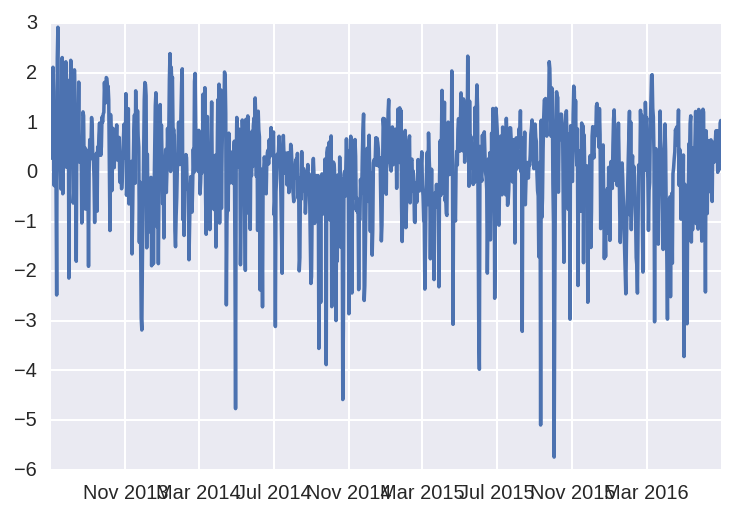

In [35]:
def plot_ewm_z(x):
    return lambda halflife: plt.plot(ewm_z(x, halflife)) and None

interact(plot_ewm_z(residuals), halflife=(5, 100, 5))

In [36]:
ewm_z(residuals, 5)[ewm_z(residuals, 5) > 2]

date
2013-07-06    2.234652
2013-07-13    2.154178
2013-07-14    2.449677
2013-07-21    2.230437
2013-09-28    2.011006
2013-11-02    2.704277
2014-01-12    2.394464
2014-01-13    2.315972
2014-02-22    2.980048
2014-02-23    2.089400
2014-03-08    2.217679
2014-04-01    2.141728
2015-04-02    2.340731
2015-04-18    2.446755
2015-05-14    2.536678
Name: count, dtype: float64

In [37]:
ewm_z(residuals, 5)[ewm_z(residuals, 5) < -4]

date
2014-04-30   -5.064805
2014-07-04   -4.516854
2014-08-12   -4.823089
2014-09-13   -5.525155
2014-09-25   -4.345008
2014-10-22   -4.819653
2015-04-20   -4.053342
2015-06-01   -4.088024
2015-08-11   -6.486068
2015-09-10   -6.800223
2015-10-02   -5.824760
2016-05-01   -4.793360
Name: count, dtype: float64

## Including windowed data in model

Instead of adapting our metric to consider recent data, we can include that recent data in the model.  Here, we two features: the count from the previous day, and a five-day rolling average.  There is a little bit of work necessary to hook all the components of the pipeline together, but in then end there is just a linear regression being performed

In [38]:
counts_df = pd.DataFrame({'counts': counts, 'previous': counts.shift(1).fillna(method='bfill'),
                          'rolling': counts.rolling(window=5).mean().shift(1).fillna(method='bfill')}) 

In [39]:
class IndexExtractor(base.BaseEstimator, base.TransformerMixin):
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return X.index

class ColumnExtractor(base.BaseEstimator, base.TransformerMixin):
    
    def __init__(self, cols):
        self.cols = cols
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return X[self.cols]

In [40]:
time_pipe = Pipeline([('index', IndexExtractor()),
                      ('features', union)])
all_union = FeatureUnion([('time_pipe', time_pipe),
                          ('columns', ColumnExtractor(['previous', 'rolling']))])
lr_pipe = Pipeline([('all_union', all_union),
                    ('lr', LinearRegression())])

In [41]:
lr_pipe.fit(counts_df, counts_df['counts'])
np.sqrt(metrics.mean_squared_error(counts_df['counts'], lr_pipe.predict(counts_df)))

5280.9055000455455

This models scores significantly better.  It is also much more stationary.

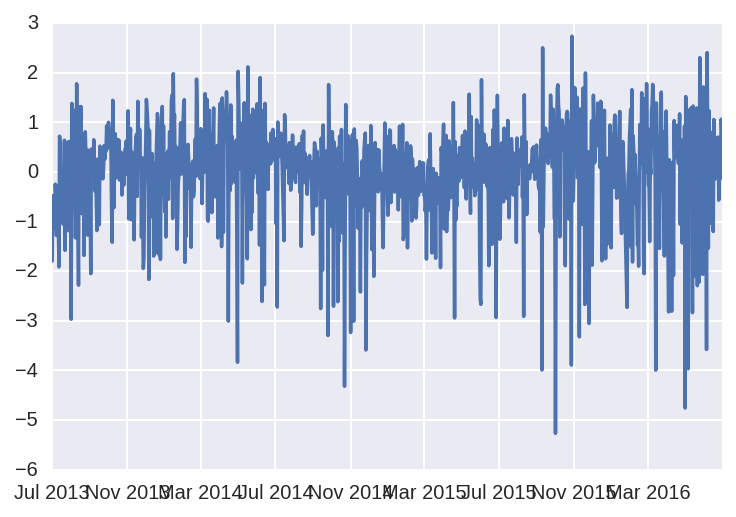

In [42]:
residuals_window = counts_df['counts'] - lr_pipe.predict(counts_df)
z_window = residuals_window / residuals_window.std()
plt.plot(z_window)

In [43]:
z_window[z_window > 2]

date
2014-05-01    2.029288
2014-05-17    2.119656
2015-09-11    2.504057
2015-10-29    2.738121
2016-05-25    2.306075
2016-06-06    2.406719
Name: counts, dtype: float64

In [44]:
z_window[z_window < -3.5]

date
2014-04-30   -3.836093
2014-10-22   -4.319922
2014-11-26   -3.589015
2015-09-10   -3.992619
2015-10-02   -5.268593
2015-10-28   -3.892991
2016-03-14   -3.994029
2016-05-01   -4.758097
2016-05-06   -3.966675
2016-06-05   -3.578224
Name: counts, dtype: float64

## Bayesian Changepoints

The previous model does a good job at producing a stationary signal, but there appear to be occasional changes in the variance.  One tool to deal with this is **Bayesian changepoint detection**.

[Bayesian changepoint detection](https://hips.seas.harvard.edu/files/adams-changepoint-tr-2007.pdf) assumes that we have a signal drawn i.i.d. from some distribution.  However, at some (randomly occuring) points in time, the parameters of that distribution change.  We keep a estimate of the probability that it has been $T$ steps from the last changepoint, for all values of $T$.  As each new measurement $X_t$ comes in, we update the probabilities for each length run, conditioned on the newest measurement.  (Therefore, we need to track the mostly-probable parameters for the distribution, given each length run.)

The algorithm needs to know what the underlying distribution is, what the Bayesian priors of the parameters are, and what the expected distribution of run lengths is.  The implementation below uses a Gaussian distribution for the samples and a geometric distribution for the run lengths.

In [45]:
# Adapted from Ryan P. Adams's Matlab code: http://hips.seas.harvard.edu/content/bayesian-online-changepoint-detection

def bayes_changepoint(X, mu0, sigma0, lambda_):
    """
    Perform Bayesian changepoint detection on an input signal X.
    
    The underlying distribution is Gaussian.  The Bayesian priors on the mean and standard
    deviation are mu0 and sigma0.  Run lengths are geometrically distributed with paramater
    lambda_.  (Equivalently, there is a probability of lambda_ of a new run starting at each
    time step.)
    
    Returns a tuple of three values:
      1) A matrix of the run length probabilities for each time step.
      2) A vector of the most probable value of the mean for each time step.
      3) A vector of the most probably value of the standard deviation for each time step.
    """
    T = len(X)
    R = np.zeros([T+1, T+1])
    R[0,0] = 1
    
    kappa0 = 1
    alpha0 = 1
    beta0 = sigma0**2 / 2

    muT = np.array(mu0)
    kappaT = np.array(kappa0)
    alphaT = np.array(alpha0)
    betaT = np.array(beta0)

    mp_mean = np.zeros(T)
    mp_std = np.zeros(T)

    maxes = np.zeros(T+1)
    for t in xrange(T):
        xt = (X[t] - muT) / np.sqrt(betaT * (kappaT+1) / (alphaT * kappaT))
        predprobs = stats.t.pdf(xt, 2 * alphaT)
        H = np.ones(t+1) / lambda_

        R[1:t+2, t+1] =  R[:t+1,t] * predprobs * (1 - H)
        R[0,     t+1] = (R[:t+1,t] * predprobs * H).sum()
        R[:,t+1] = R[:,t+1] / R[:,t+1].sum()  # Numerics

        mp = R[:, t+1].argmax()

        muT0 = np.r_[mu0, (kappaT * muT + X[t]) / (kappaT + 1)]
        kappaT0 = np.r_[kappa0, kappaT + 1]
        alphaT0 = np.r_[alpha0, alphaT + 0.5]
        betaT0 = np.r_[beta0, betaT + (kappaT * (X[t] - muT)**2 / (2 * (kappaT + 1)))]

        muT = muT0
        kappaT = kappaT0
        alphaT = alphaT0
        betaT = betaT0

        mp_mean[t] = muT[mp]
        mp_std[t] = np.sqrt(betaT[mp] * (kappaT[mp] + 1) / (alphaT[mp] * kappaT[mp]))
    
    return R, mp_mean, mp_std

/home/ariel/miniconda2/envs/pydata/lib/python2.7/site-packages/ipykernel/__main__.py:2: RuntimeWarning: divide by zero encountered in log10
  from ipykernel import kernelapp as app


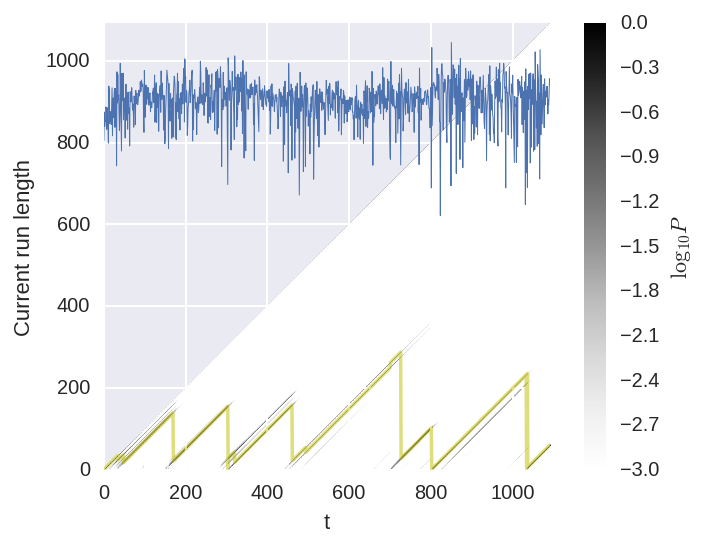

In [46]:
R, mp_mean, mp_std = bayes_changepoint(residuals_window, 0, residuals_window.std(), 1000)
plt.imshow(np.log10(R), vmin=-3, origin='lower')
plt.colorbar(label=r'$\log_{10} P$')
plt.plot(residuals_window.values/100 + 900, lw=0.5)
plt.plot(R.argmax(axis=0), alpha=0.5, c='y')
plt.axis([0,len(residuals_window),0,len(residuals_window)])
plt.xlabel('t')
plt.ylabel('Current run length')

The black-and-white plot shows the logarithm of the probability of having a run of a particular length at time $t$.  The yellow line highlights the most probable run length at each time.  The saw-tooth pattern shows that, at most times, the most-probable run length increases by one.  In other words, each increasing line indicates a single run, and each point where the curve drops down to (or near) zero indicates a new changepoint.  The fact that each saw-tooth starts near the x-axis indicates that the algorithm detects changepoints soon after they occur.

The (residual of the) signal is plotted in blue.  You can notice that most of the changepoints correspond to a change in the variance of the signal.

From the most probable run, we can calculate the mean and standard deviation associated with that run.  This provides another way to calculate a moving z-score.

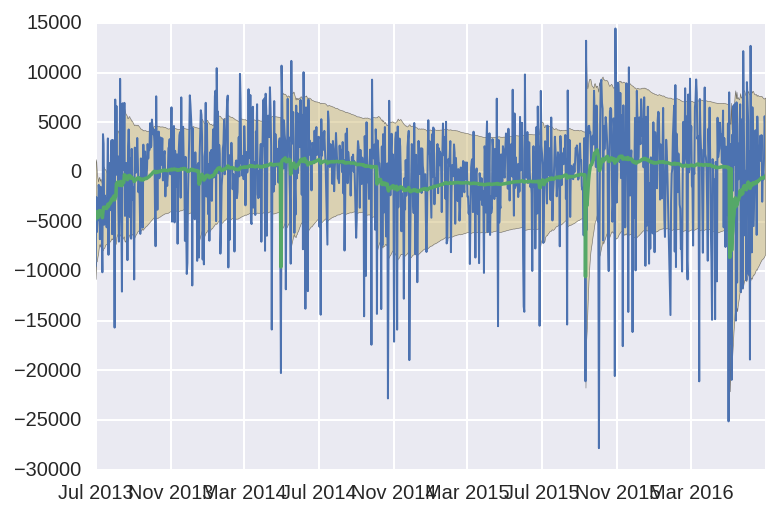

In [47]:
plt.plot(residuals_window, lw=1)
plt.fill_between(residuals_window.index, mp_mean+mp_std, mp_mean-mp_std, facecolor=cols[1], alpha=0.5)
plt.plot(residuals_window.index, mp_mean)

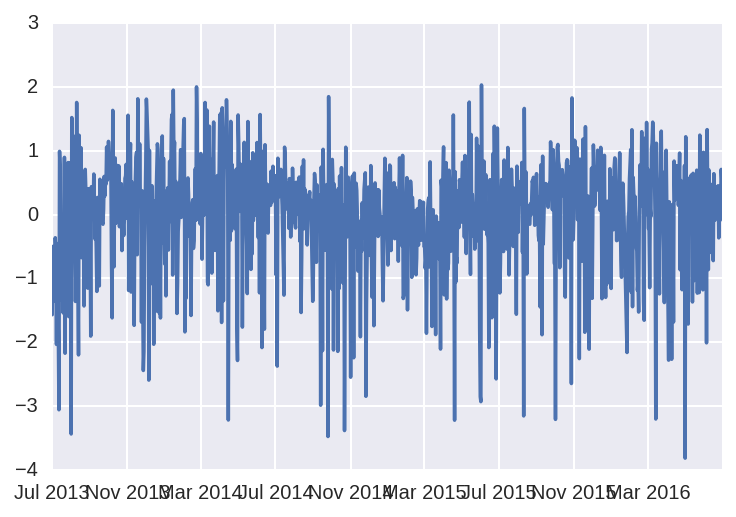

In [48]:
plt.plot(residuals_window / mp_std)

## Online Learning

So far, we have been doing only retrospective analysis of the data.  In practice, we want to analyze incoming data in real time.  While we could train a model on an initial set of data and use that to analyze the future input, this means we don't learn anything from that future data.  (Extrapolation is also very dangerous if you have a quadratic background term.)

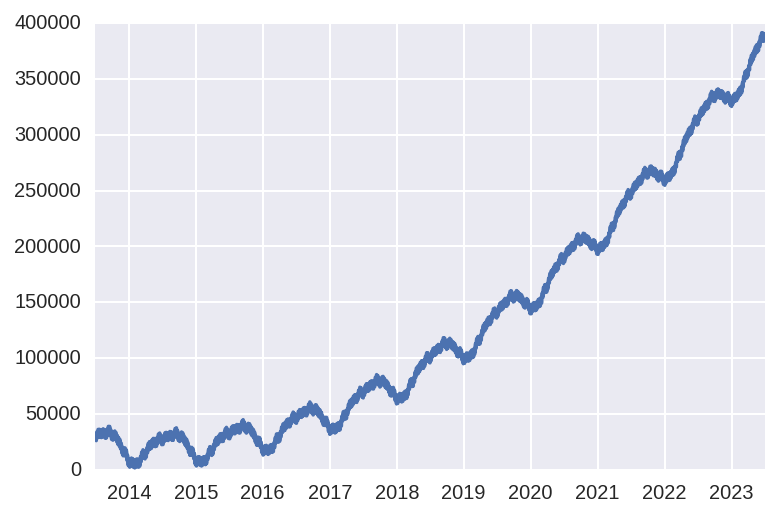

In [49]:
future_dates = pd.date_range('2013-07-01', '2023-07-01', freq='d')
plt.plot(future_dates, pipe.predict(future_dates))

We can avoid retraining the model each time we get new data by using an **online** learning algorithm, which is able to update itself with new data.  An exponentially-weighted moving average can be thought of as a simple online learning algorithm.  We can update its value from only the current value and the new measurement.  (In contrast, a rolling window requires us to store all the values in the window and recalculate the mean each step.)

The Bayesian changepoint algorithm shown above is also an online learning model, as it updates its state for each new sample.  As implemented above, its memory requirements would grow with the length of the data, as it considers run lengths that go back to $t=0$.  This could be avoided by truncating long run lengths when their probability falls below some threshold.

Linear regression does not support online learning.  However, stochastic gradient descent does.  Like linear regression, this is also a linear model.  Instead of finding an exact solution with matrix operations, stochastic gradient descent goes through the data row by row, updating its parameters slightly each time to reduce an error function.  Thus, it naturally supports online learning.

In Scikit Learn, estimators that support online learning do so through a `partial_fit()` method.  Unfortunately, the default `Pipeline` class does not support `partial_fit()`, so we implement it ourselves.

In [50]:
class PartialFitPipeline(Pipeline):
    
    def partial_fit(self, X, y):
        # Assume that transformers without a partial_fit method can be skipped
        Xtrans = X
        for _, step in self.steps[:-1]:
            if hasattr(step, 'partial_fit'):
                step.partial_fit(Xtrans, y)
            Xtrans = step.transform(Xtrans)
        self.steps[-1][1].partial_fit(Xtrans, y)
        return self

sgd_pipe = PartialFitPipeline([('all_union', all_union),
                               ('scaler', StandardScaler()),
                               ('sgd', SGDRegressor())])

We use an exponential weighted moving average, since it's easier to manage in online learning.  Stochastic gradient descent is sensitive to different scales of data, so we need to normalize the features coming in.

In [51]:
counts_init = counts.iloc[:700]
counts_online = counts.iloc[700:]
counts_init_df = pd.DataFrame({'counts': counts_init,
                               'previous': counts_init.shift(1).fillna(method='bfill'),
                               'rolling': counts_init.ewm(halflife=5).mean().shift(1).fillna(method='bfill')}) 
sgd_pipe.fit(counts_init_df, counts_init_df['counts'])

PartialFitPipeline(steps=[('all_union', FeatureUnion(n_jobs=1,
       transformer_list=[('time_pipe', Pipeline(steps=[('index', IndexExtractor()), ('features', FeatureUnion(n_jobs=1,
       transformer_list=[('date', QuadBackground()), ('fourier-y', FourierComponents(period=365)), ('fourier-2', FourierComponents(perio..., penalty='l2', power_t=0.25,
       random_state=None, shuffle=True, verbose=0, warm_start=False))])

At each step, we make a prediction for the incoming record.  Then we train the model on the new record and update for the next record.

In [52]:
last_count = counts_init_df['counts'].iloc[-1]
alpha = 1 - 1./2**5
ewm = counts_init_df['rolling'].iloc[-1]
predictions = []
coefs = []

for date, count in counts_online.iteritems():
    df = pd.DataFrame({'counts': count, 'previous': last_count, 'rolling': ewm}, index=[date])
    predictions.append(sgd_pipe.predict(df))
    sgd_pipe.partial_fit(df, df['counts'])
    coefs.append(sgd_pipe.named_steps['sgd'].coef_.copy())
    last_count = count
    ewm = alpha * count + (1 - alpha) * ewm

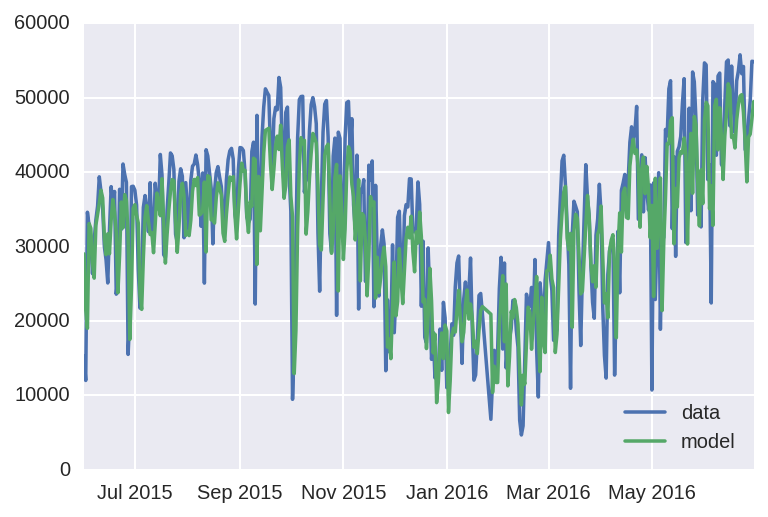

In [53]:
plt.plot(counts_online, label='data')
plt.plot(counts_online.index, predictions, label='model')
plt.legend(loc=4)

We can see that the model is adjusting the coefficients over time, as it continues to learn from the new data.

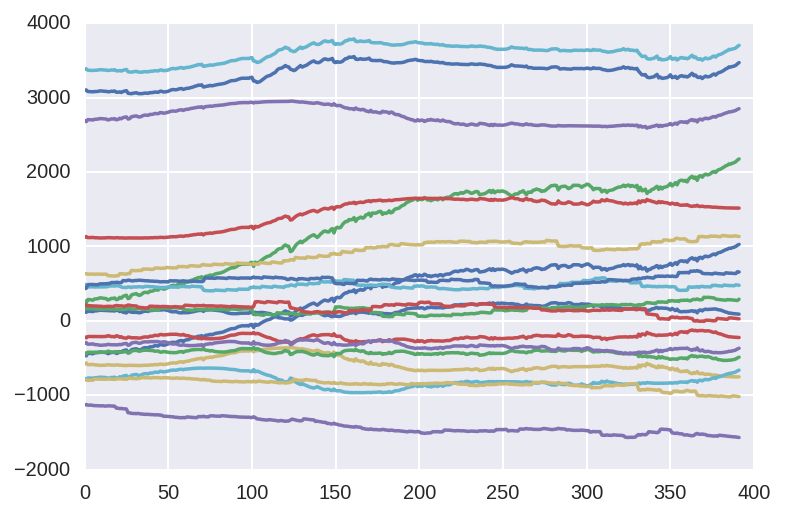

In [54]:
plt.plot(coefs)

**Excercises:**

1. Add more lagged or windowed data to the model, and see if its performance can be improved.  Beware that, if too many features are added, there is a danger of overfitting.

2. Perform anomaly detection on the temperature data from the Central Park weather station.  Do temperature anomalies tend to align with ridership anomalies?  Add features to the ridership model corresponding to the temperature anomaly.  How does the performace of this model compare to one that involves temperature directly?

3. We have been looking at only aggregate data so far.  Instead, look at the ridership at a particular station, and try to detect anomalies in its data.  Do these anomalies line up wit the system-wide anomalies or not?

## References

- ["Bayesian Online Changepoint Detection"](http://hips.seas.harvard.edu/content/bayesian-online-changepoint-detection), by Ryan Prescott Adams and David J.C. MacKay
- ["Is Seattle Really Seeing an Uptick In Cycling?"](https://jakevdp.github.io/blog/2014/06/10/is-seattle-really-seeing-an-uptick-in-cycling/), by Jake VanderPlas
- ["Anomaly Detection"](https://turi.com/learn/userguide/anomaly_detection/intro.html), Turi User Guide

Scikit Learn offer anomaly detection with [One-class SVM](http://scikit-learn.org/stable/auto_examples/svm/plot_oneclass.html#sphx-glr-auto-examples-svm-plot-oneclass-py) and [Isolation Forest](http://scikit-learn.org/stable/auto_examples/ensemble/plot_isolation_forest.html#sphx-glr-auto-examples-ensemble-plot-isolation-forest-py).

*Copyright &copy; 2016 The Data Incubator.  All rights reserved.*